In [1]:
# Importing all required libraries 

import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

Step 1
Data Preparation or Preprocessing 
1. Load the MNIST dataset
2. Display few images after loading dataset 
3. Normlaize the images so that the pixel values are in between 0 and 1
4. Split the dataset into Training and Testing samples


In [2]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()


# Concatenate x_train and x_test arrays
X = np.concatenate((x_train, x_test), axis=0)

# Concatenate y_train and y_test arrays
y = np.concatenate((y_train, y_test), axis=0)

print("Shape of X:", X.shape)
print("Shape of y", y.shape)

Shape of X: (70000, 28, 28)
Shape of y (70000,)


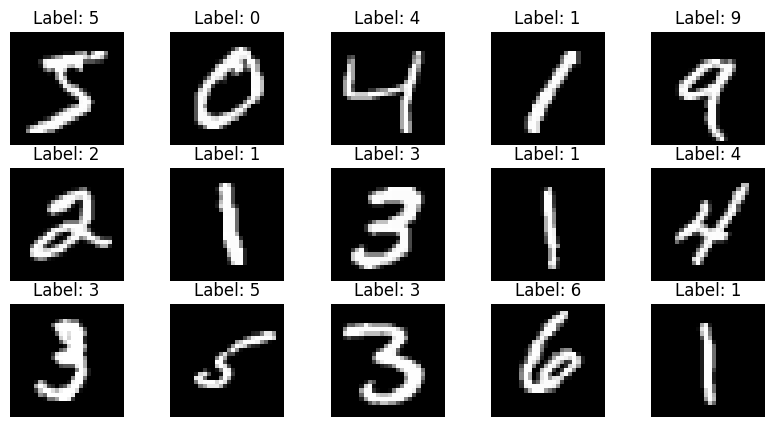

In [3]:
# Displaying first few images

plt.figure(figsize=(10, 5))
for i in range(15):
    plt.subplot(3,5,i + 1)
    plt.imshow(X[i], cmap='gray')
    plt.title(f'Label: {y[i]}')
    plt.axis('off')
plt.show()

In [4]:
# Flatten the input data
X = X.reshape((X.shape[0], -1))
print("Shape of data after flattening input",X.shape)

Shape of data after flattening input (70000, 784)


In [5]:
# Normalize the images so that pixel values are between 0 and 1
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

In [6]:
# Split the dataset into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

print("Training set X shape:", X_train.shape)
print("Training set y shape:", y_train.shape)
print("Testing set X shape:", X_test.shape)
print("Testing set y shape:", y_test.shape)

Training set X shape: (56000, 784)
Training set y shape: (56000,)
Testing set X shape: (14000, 784)
Testing set y shape: (14000,)


Step 2: Applying SVD for Dimensionality Reduction

1. Defining function to perform SVD on input matrix (X_normalized)
2. Evaluation the variance and cummulative variance of data 
3. Plotting the graph to show the visualization of cummulative variance using SVD vs Singular values


In [7]:
# Function to perform the SVD 

def perform_svd(input_data_matrix,full_matrices = False):
    # Decompose the given matrix to left (U) , right (VT) singular matrix and Singular values(S)
    U, S, VT = np.linalg.svd(input_data_matrix, full_matrices=False)
    return U, S , VT


In [8]:
# Apply Singular Value Decomposition (SVD)
U, Sigma, VT = perform_svd(X_normalized, full_matrices= False)

Formula to evaluate explained variance and cummulative variance using SVD 

     explained_variance = (Sigma**2) / np.sum(Sigma**2)

     cumulative_variance = np.cumsum(explained_variance)
     

In [9]:
# Truncate small singular values and compute explained variance
# Calculate the variance explained by each singular value

explained_variance = (Sigma**2) / np.sum(Sigma**2)
cumulative_variance = np.cumsum(explained_variance)


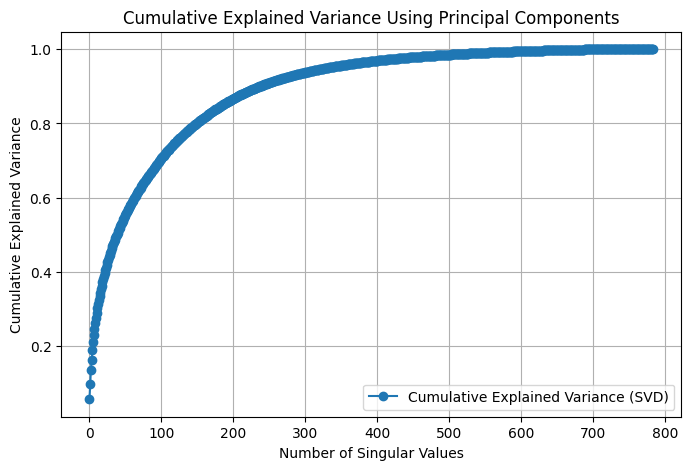

In [10]:
# Plot the cumulative explained variance to determine how many components to retain
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o', label='Cumulative Explained Variance (SVD)')
plt.xlabel('Number of Singular Values')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Using Principal Components')
plt.legend()
plt.grid()
plt.show()

Step 3  SVD for Dimensionality Reduction and Data Preparation

1. Choosing the top k components to retain 90% and 95% of variance respectively 
2. Evaluating the X_reduced_svd matrix values to train the model
3. Defining function to calculate Image compression and PSNR after SVD 
4. Plotting the original and reconstructed images after performing svd
5. Spliting the SVD reduced data to traning and testing samples
   

In [11]:
# Choose k components that explain a desired amount of variance (e.g., 90%)
k_svd_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components to retain 90% variance using SVD: {k_svd_90}")

# Evaluating X_reduced_svd for n components which retain 90% variance
X_reduced_svd_90 = np.dot(U[:, :k_svd_90], np.diag(Sigma[:k_svd_90]))


Number of components to retain 90% variance using SVD: 238


In [12]:
# Project the data using the top k singular values
# Choose k components that explain a desired amount of variance (e.g., 95%)
k_svd_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components to retain 95% variance using SVD: {k_svd_95}")

# Evaluting X_reduced_svd for n components which retain 95% variance
X_reduced_svd_95 = np.dot(U[:, :k_svd_95], np.diag(Sigma[:k_svd_95]))

Number of components to retain 95% variance using SVD: 332


In [13]:
# Reconstruct images from the reduced data
X_reconstructed_90 = np.dot(X_reduced_svd_90, VT[:k_svd_90, :])
X_reconstructed_95 = np.dot(X_reduced_svd_95, VT[:k_svd_95, :])

# Function to calculate PSNR
def calculate_psnr(original, reconstructed, max_pixel=1.0):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')  # No difference between images
    psnr = 10 * np.log10((max_pixel ** 2) / mse)
    return psnr

# Function to calculate Compression Ratio
def calculate_compression_ratio(original_shape, reduced_components):
    original_size = np.prod(original_shape)  # Total elements in the original data
    compressed_size = original_shape[0] * reduced_components + reduced_components * original_shape[1]
    return original_size / compressed_size

# Calculate compression ratios
compression_ratio_90 = calculate_compression_ratio(X.shape, k_svd_90)
compression_ratio_95 = calculate_compression_ratio(X.shape, k_svd_95)

print(f"Compression Ratio (90% variance): {compression_ratio_90:.2f}")
print(f"Compression Ratio (95% variance): {compression_ratio_95:.2f}")

# Calculate PSNR for reconstructed images
psnr_90 = calculate_psnr(X_normalized, X_reconstructed_90)
psnr_95 = calculate_psnr(X_normalized, X_reconstructed_95)

print(f"PSNR (90% variance): {psnr_90:.2f} dB")
print(f"PSNR (95% variance): {psnr_95:.2f} dB")


Compression Ratio (90% variance): 3.26
Compression Ratio (95% variance): 2.34
PSNR (90% variance): 10.40 dB
PSNR (95% variance): 13.39 dB


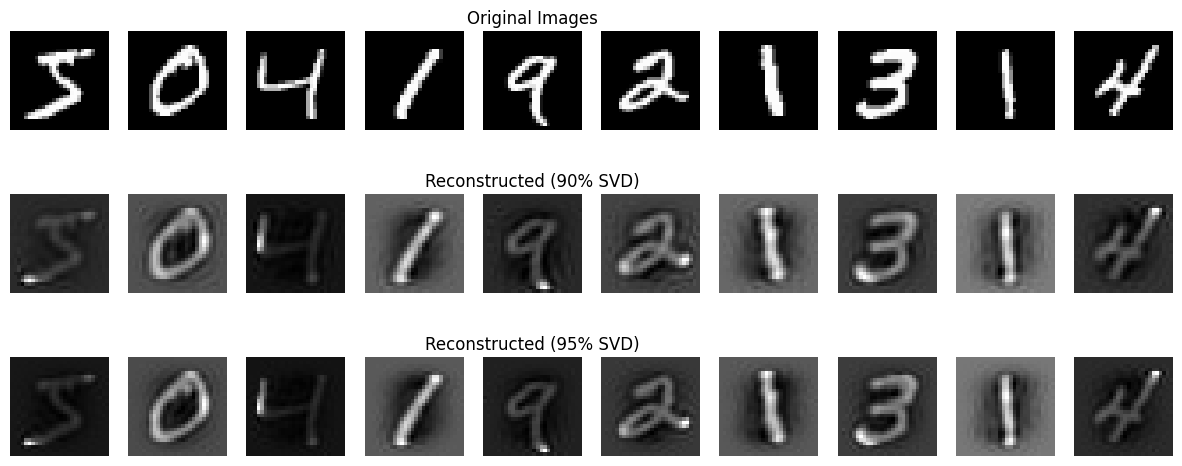

In [14]:
# Visualize original and reconstructed images
def plot_images(original, reconstructed_90, reconstructed_95, n_images=10):
    plt.figure(figsize=(15, 6))
    
    for i in range(n_images):
        # Original images
        plt.subplot(3, n_images, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == n_images // 2 - 1:
            plt.title("Original Images")
        
        # Reconstructed images (90% variance SVD)
        plt.subplot(3, n_images, i + 1 + n_images)
        plt.imshow(reconstructed_90[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == n_images // 2 - 1:
            plt.title("Reconstructed (90% SVD)")
        
        # Reconstructed images (95% variance SVD)
        plt.subplot(3, n_images, i + 1 + 2 * n_images)
        plt.imshow(reconstructed_95[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == n_images // 2 - 1:
            plt.title("Reconstructed (95% SVD)")

# Plot some images
n_samples_to_plot = 10
plot_images(X[:n_samples_to_plot], X_reconstructed_90[:n_samples_to_plot], X_reconstructed_95[:n_samples_to_plot])
plt.show()

In [15]:
# Split the SVD-reduced data

# Splitting the data for k_svd_90 components
X_train_svd_90, X_test_svd_90, _, _ = train_test_split(X_reduced_svd_90, y, test_size=0.2, random_state=42)

# Splitting the data for k_svd_95 components
X_train_svd_95, X_test_svd_95, _, _ = train_test_split(X_reduced_svd_95, y, test_size=0.2, random_state=42)



Step 4  Applying PCA and Defining Classifiers

1. Apply PCA for choosen k_pca components and split the testing and traning samples for pca
2. Split the PCA applied  data to traning and testing samples
3. Define the classifier function to perform classifiction 

In [16]:
# Fit PCA with all components to compute explained variance
pca_full = PCA()
pca_full.fit(X_normalized)

# Compute cumulative variance and determine k for 90% variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
k_pca_90 = np.argmax(cumulative_variance >= 0.90) + 1  # +1 to account for zero-indexing
print(f"Number of components to retain 90% variance: {k_pca_90}")

# Apply PCA with the determined number of components
pca = PCA(n_components=k_pca_90)
X_reduced_pca_90 = pca.fit_transform(X_normalized)

# Split the PCA-reduced data
X_train_pca_90, X_test_pca_90, _, _ = train_test_split(X_reduced_pca_90, y, test_size=0.2, random_state=42)

Number of components to retain 90% variance: 238


In [17]:

# Fit PCA with all components to compute explained variance
pca_full = PCA()
pca_full.fit(X_normalized)

# Compute cumulative variance and determine k for 95% variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
k_pca_95 = np.argmax(cumulative_variance >= 0.95) + 1  # +1 to account for zero-indexing
print(f"Number of components to retain 95% variance: {k_pca_95}")

# Apply PCA with the determined number of components
pca = PCA(n_components=k_pca_95)
X_reduced_pca_95 = pca.fit_transform(X_normalized)

# Split the PCA-reduced data
X_train_pca_95, X_test_pca_95, _, _ = train_test_split(X_reduced_pca_95, y, test_size=0.2, random_state=42)

Number of components to retain 95% variance: 332


In [18]:
def model(X_train,y_train, X_test):
    start_time = time.time()
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    time_taken= time.time() - start_time
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return  accuracy,time_taken


Step 5 Model Training and Results Visualization

1. Train on Original Data: Train and evaluate the model on the original dataset, recording accuracy and time.
2. Train on SVD Data (90%): Train and evaluate the model on the SVD-reduced dataset with 90% variance retained.
3. Train on SVD Data (95%): Train and evaluate the model on the SVD-reduced dataset with 95% variance retained.
4. Train on PCA Data: Train and evaluate the model on PCA-reduced datasets with 90% and 95% variance retained.
5. Plot the graph (bar plot) to compare the accuracies and train time of different methods 


In [19]:
# Evaluate accuracy and training time of the model on the original dataset
accuracy_orig, time_taken_orig = model(X_train, y_train, X_test)
print(f"Original Data - Accuracy: {accuracy_orig * 100:.2f}%, Time Taken: {time_taken_orig:.2f} seconds")

# Evaluate accuracy and training time of the model on SVD-reduced data with 90% variance retained
accuracy_svd_90, time_taken_svd_90 = model(X_train_svd_90, y_train, X_test_svd_90)
print(f"SVD-Reduced Data (k=238) - Accuracy: {accuracy_svd_90 * 100:.2f}%, Time Taken: {time_taken_svd_90:.2f} seconds")

# Evaluate accuracy and training time of the model on SVD-reduced data with 95% variance retained
accuracy_svd_95, time_taken_svd_95 = model(X_train_svd_95, y_train, X_test_svd_95)
print(f"SVD-Reduced Data (k=332) - Accuracy: {accuracy_svd_95 * 100:.2f}%, Time Taken: {time_taken_svd_95:.2f} seconds")

# Evaluate accuracy and training time of the model on PCA-reduced data with 90% variance retained
accuracy_pca_90, time_taken_pca_90 = model(X_train_pca_90, y_train, X_test_pca_90)
print(f"PCA-Reduced Data (k=238) - Accuracy: {accuracy_pca_90 * 100:.2f}%, Time Taken: {time_taken_pca_90:.2f} seconds")

# Evaluate accuracy and training time of the model on PCA-reduced data with 95% variance retained
accuracy_pca_95, time_taken_pca_95 = model(X_train_pca_95, y_train, X_test_pca_95)
print(f"PCA-Reduced Data (k=332) - Accuracy: {accuracy_pca_95 * 100:.2f}%, Time Taken: {time_taken_pca_95:.2f} seconds")


Original Data - Accuracy: 91.62%, Time Taken: 21.90 seconds
SVD-Reduced Data (k=238) - Accuracy: 92.14%, Time Taken: 9.94 seconds
SVD-Reduced Data (k=332) - Accuracy: 92.18%, Time Taken: 11.81 seconds
PCA-Reduced Data (k=238) - Accuracy: 92.03%, Time Taken: 9.83 seconds
PCA-Reduced Data (k=332) - Accuracy: 92.26%, Time Taken: 12.08 seconds


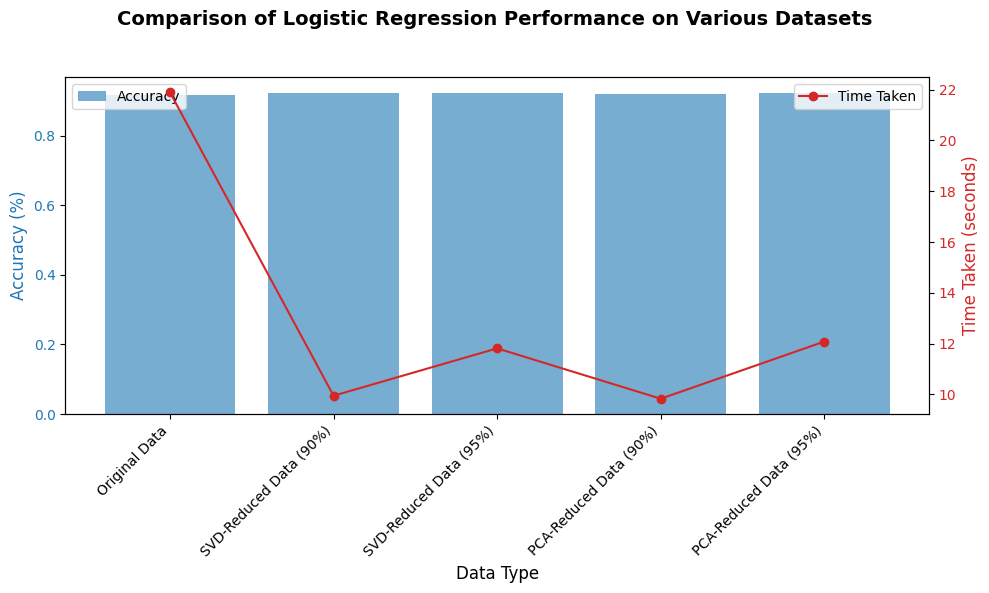

In [20]:

# Plot the comparison
labels = ['Original Data', 'SVD-Reduced Data (90%)', 'SVD-Reduced Data (95%)', 
          'PCA-Reduced Data (90%)', 'PCA-Reduced Data (95%)']
accuracy = [accuracy_orig, accuracy_svd_90, accuracy_svd_95, accuracy_pca_90, accuracy_pca_95]
time_taken = [time_taken_orig, time_taken_svd_90, time_taken_svd_95, time_taken_pca_90, time_taken_pca_95]

x = np.arange(len(labels))  # Label locations

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot accuracy as bars
ax1.bar(x, accuracy, color='tab:blue', alpha=0.6, label='Accuracy')
ax1.set_xlabel('Data Type', fontsize=12)
ax1.set_ylabel('Accuracy (%)', color='tab:blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)

# Plot time taken as a line chart
ax2 = ax1.twinx()
ax2.plot(x, time_taken, color='tab:red', marker='o', label='Time Taken')
ax2.set_ylabel('Time Taken (seconds)', color='tab:red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add legends, title, and layout adjustments
fig.suptitle('Comparison of Logistic Regression Performance on Various Datasets', fontsize=14, fontweight='bold')
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()
